In [1]:
# TensorFlow and Keras Imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, metrics
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint

# Image Processing Libraries
import cv2
from cv2 import imread,resize
from scipy.ndimage import label, find_objects

# Data Handling Libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# File and Operating System Libraries
import os

# Warnings Management
import warnings
warnings.filterwarnings('ignore')

# GPU Configuration
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
print(tf.config.list_physical_devices('GPU'))

# PATHS
IMG_PATH = '/home/ccc/Downloads/lung/Chest-X-Ray/Chest-X-Ray/image/'
MSK_PATH = '/home/ccc/Downloads/lung/Chest-X-Ray/Chest-X-Ray/mask/'

2025-07-09 18:12:57.108002: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-09 18:12:57.328945: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-09 18:12:57.329055: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-09 18:12:57.373017: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-09 18:12:57.464768: I tensorflow/core/platform/cpu_feature_guar

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2025-07-09 18:13:00.341838: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-09 18:13:00.452938: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-09 18:13:00.453193: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [2]:
metadata = pd.read_csv('/home/ccc/Downloads/lung/MetaData.csv')
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 704 entries, 0 to 703
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       704 non-null    int64 
 1   gender   704 non-null    object
 2   age      704 non-null    object
 3   county   704 non-null    object
 4   ptb      704 non-null    int64 
 5   remarks  699 non-null    object
dtypes: int64(2), object(4)
memory usage: 33.1+ KB


In [3]:
metadata.head()

id gender age    county  ptb                                      remarks
0  1000   male  31  Shenxhen    0                                       normal
1  1001   male  64  Shenxhen    0                                       normal
2  1002   male  35  Shenxhen    0                                       normal
3  1003   male  32  Shenxhen    1               STB,ATB,tuberculosis pleuritis
4  1004   male   2  Shenxhen    1  secondary PTB  in the bilateral upper field

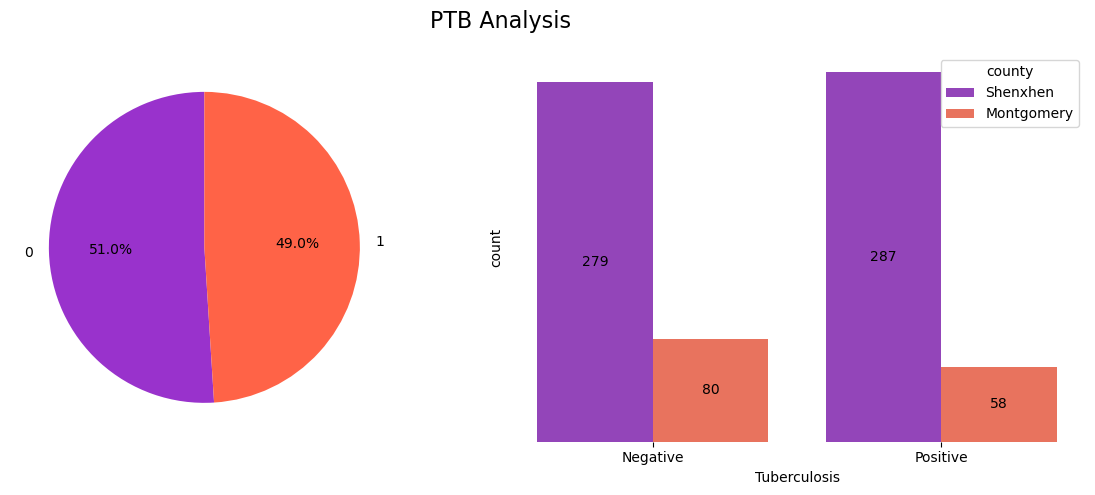

In [4]:
agg_data = metadata.ptb.value_counts()
ct = pd.crosstab(metadata['gender'], metadata['ptb'])

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.pie(agg_data,labels=agg_data.index,autopct='%1.1f%%', startangle=90,colors=['darkorchid','tomato'])

plt.subplot(122)
bars = sns.countplot(metadata,x='ptb',hue='county',palette=['darkorchid','tomato'])
plt.bar_label(bars.containers[0], label_type='center')
plt.bar_label(bars.containers[1], label_type='center')
plt.yticks([])
plt.xticks([0,1],labels=['Negative','Positive'])
plt.xlabel('Tuberculosis')
plt.box(False)

plt.suptitle('PTB Analysis',fontsize=16)
plt.tight_layout()
plt.show()

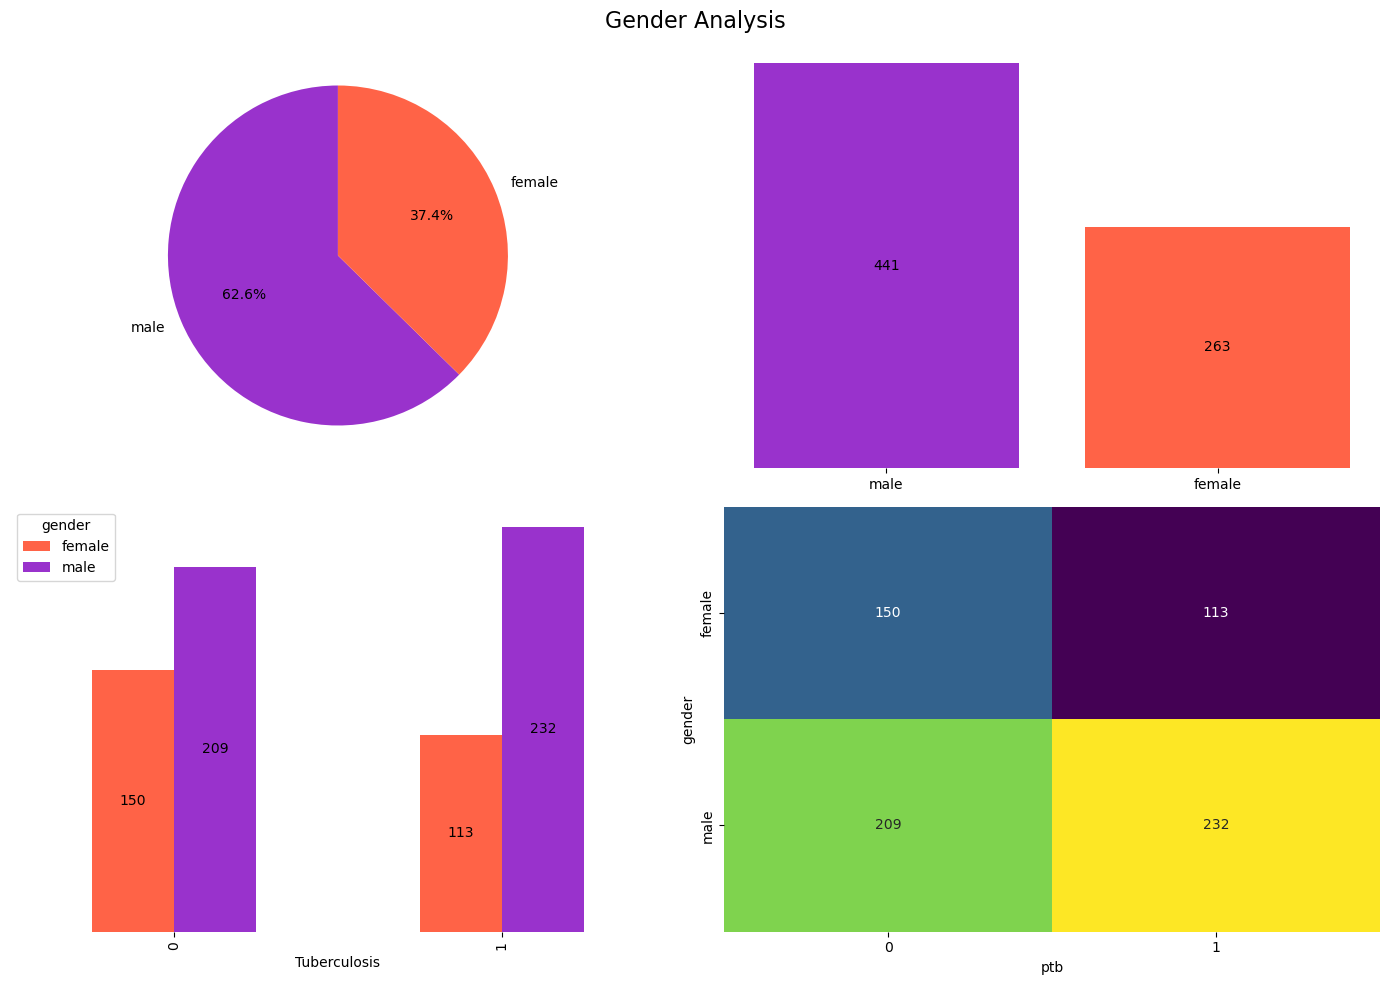

In [5]:
gender_mapping = {
    'm': 'male', 'Male,': 'male', 'male35yrs': 'male', 'male,':'male',
    'f': 'female', 'femal': 'female', 'female24yrs':'female','o':'female','female,':'female'
}
metadata.gender = metadata.gender.str.lower()
metadata.gender.replace(gender_mapping,inplace=True)
agg_data = metadata.gender.value_counts()
ct = pd.crosstab(metadata['gender'], metadata['ptb'])

plt.figure(figsize=(14,10))
plt.subplot(221)
plt.pie(agg_data,labels=agg_data.index,autopct='%1.1f%%', startangle=90,colors=['darkorchid','tomato'])

plt.subplot(222)
bars = plt.bar(agg_data.index,agg_data,color=['darkorchid','tomato'])
plt.bar_label(bars, labels=[str(height) for height in agg_data],label_type='center')
plt.yticks([])
plt.box(False)

plt.subplot(223)
bars = ct.T.plot(kind='bar', color=['tomato', 'darkorchid'],ax=plt.gca())
plt.bar_label(bars.containers[0], label_type='center')
plt.bar_label(bars.containers[1], label_type='center')
plt.xlabel('Tuberculosis')
plt.yticks([])
plt.box(False)

plt.subplot(224)
sns.heatmap(ct,annot=True,cbar=False,fmt='d',cmap='viridis')

plt.suptitle('Gender Analysis',fontsize=16)
plt.tight_layout()
plt.show()

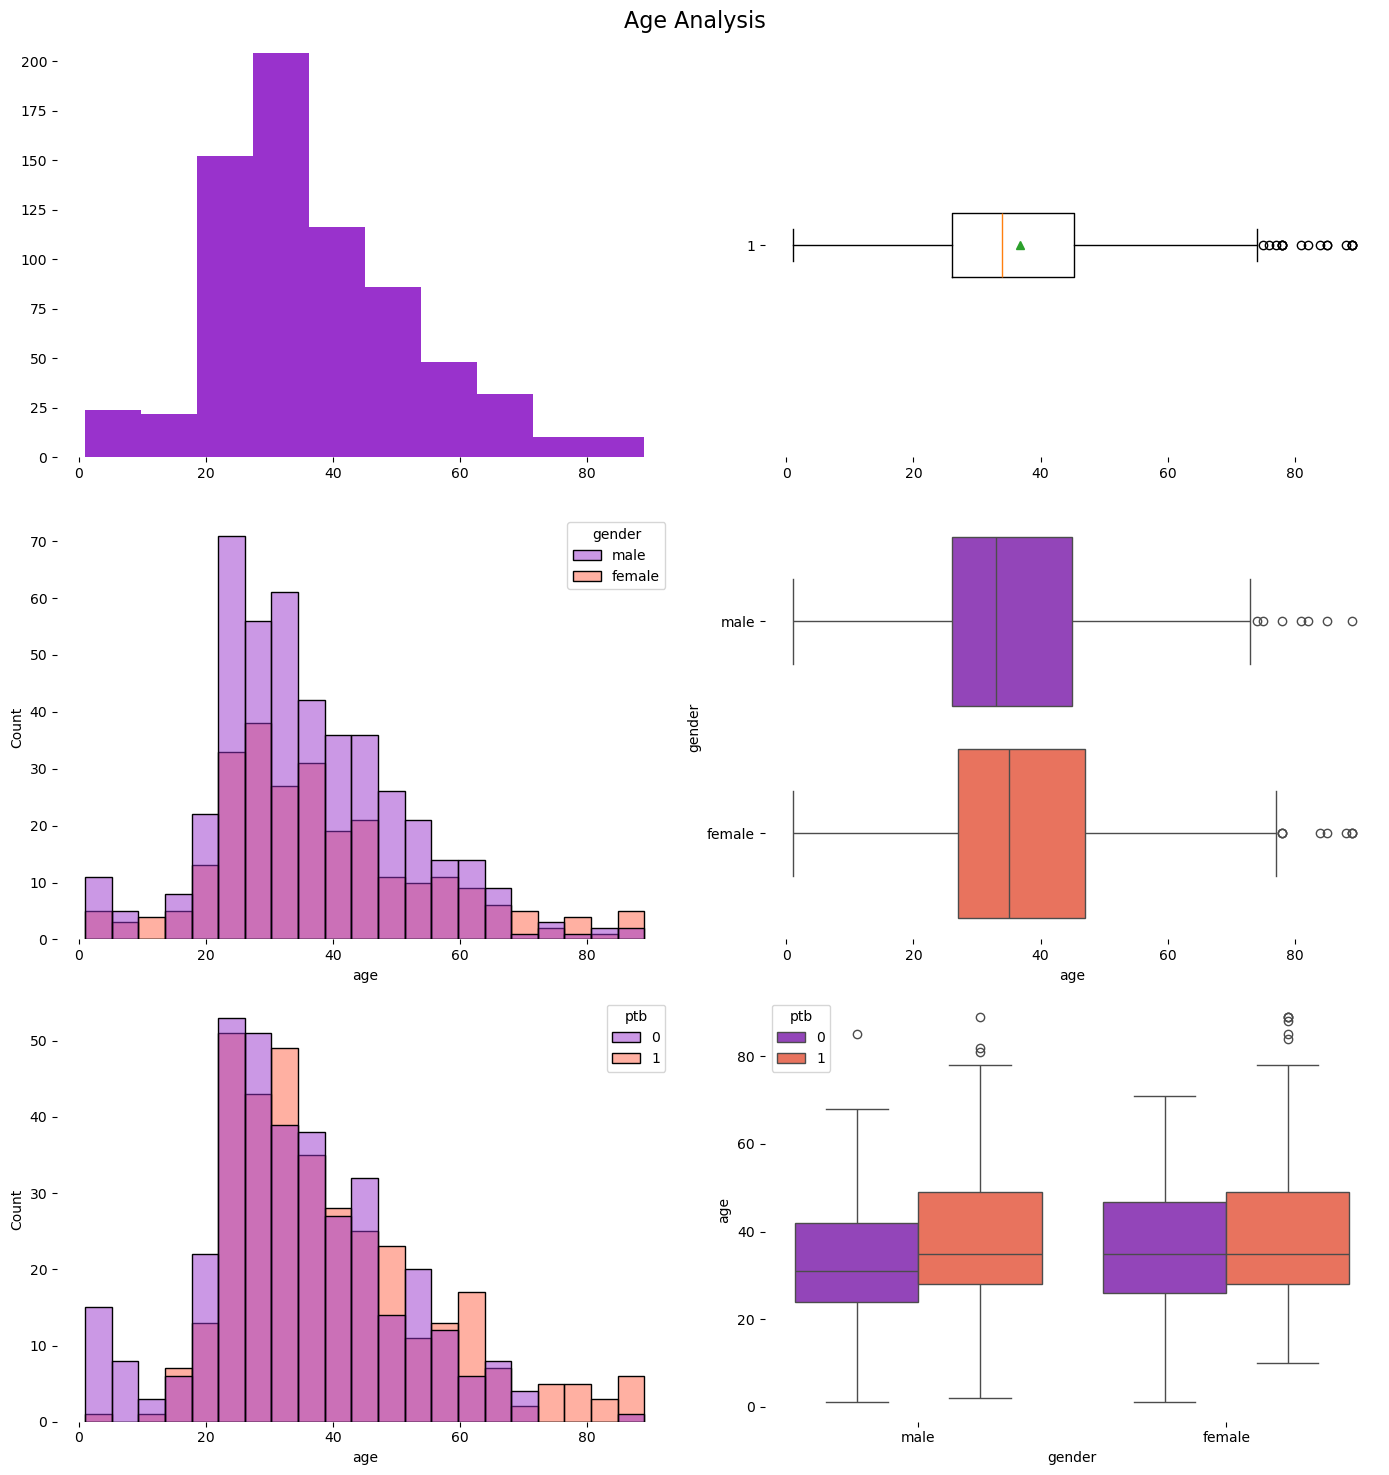

In [6]:
metadata.age = (metadata.age
                .replace({'16month':'1','39yr':'39','1yr':'1','male35':'35','female24':'24'})
                .astype(int))
custom_palette = ['darkorchid','tomato']

plt.figure(figsize=(14,15))
plt.subplot(321)
plt.hist(metadata.age,color='darkorchid')
plt.box(False)

plt.subplot(322)
plt.boxplot(metadata.age,vert=False,showmeans=True)
plt.box(False)

plt.subplot(323)
sns.histplot(metadata,x='age',hue='gender',palette=custom_palette)
plt.box(False)

plt.subplot(324)
sns.boxplot(metadata,x='age',y='gender',palette=custom_palette)
plt.box(False)

plt.subplot(325)
sns.histplot(metadata,x='age',hue='ptb',palette=custom_palette)
plt.box(False)

plt.subplot(326)
sns.boxplot(data=metadata, x='gender', y='age', hue='ptb', palette=custom_palette)
plt.box(False)


plt.suptitle('Age Analysis',fontsize=16)
plt.tight_layout()
plt.show()

<Figure size 1400x800 with 0 Axes>

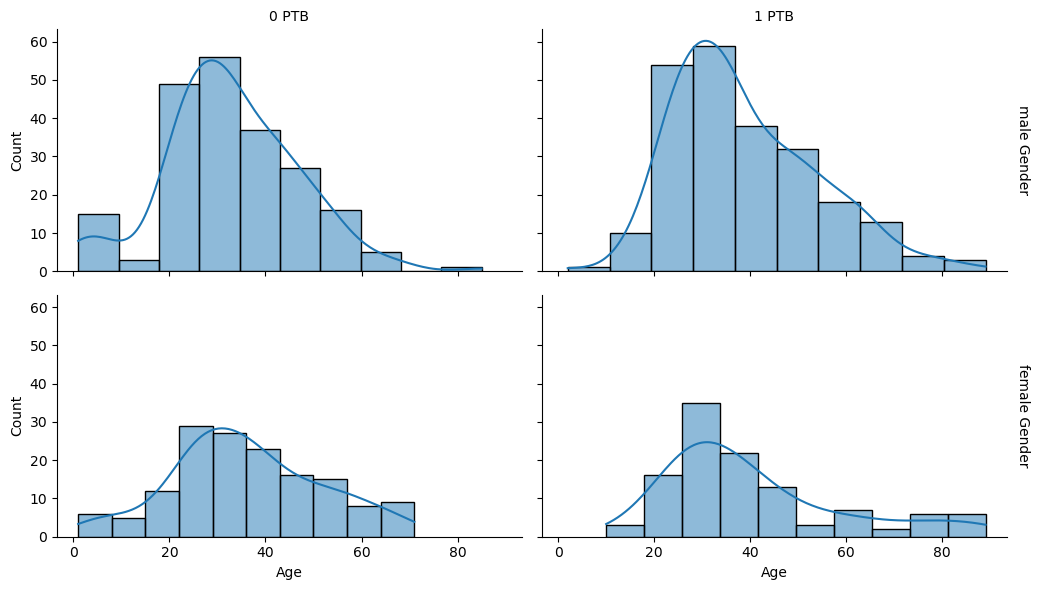

In [7]:
# FacetGrid of Age by Gender and PTB
plt.figure(figsize=(14,8))
g = sns.FacetGrid(metadata, col='ptb', row='gender', margin_titles=True,aspect=1.75)
g.map(sns.histplot, 'age', bins=10, kde=True)

# Adding titles and labels
g.set_axis_labels('Age', 'Count')
g.set_titles(col_template="{col_name} PTB", row_template="{row_name} Gender")

# Show the plot
plt.show()


## <p style="font-size: 36px;background-color:#6A0DAD; color:white; padding:10px 20px; width:95%; border-radius:15px; text-align:center;margin: 0 auto;font-weight: bold;">Lungs Mask</p>

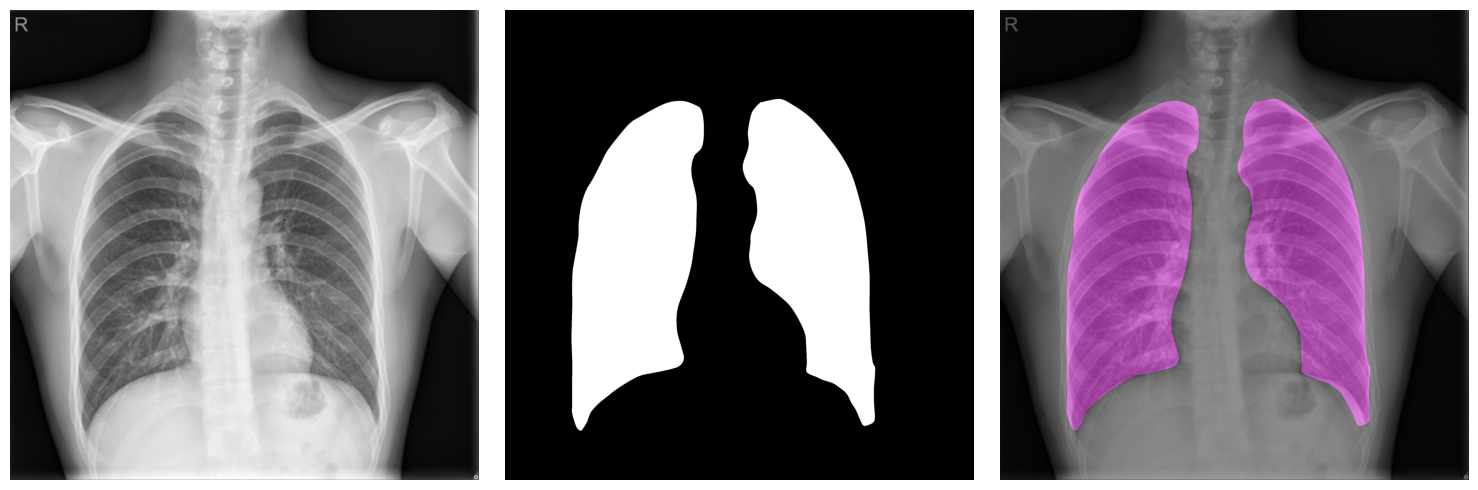

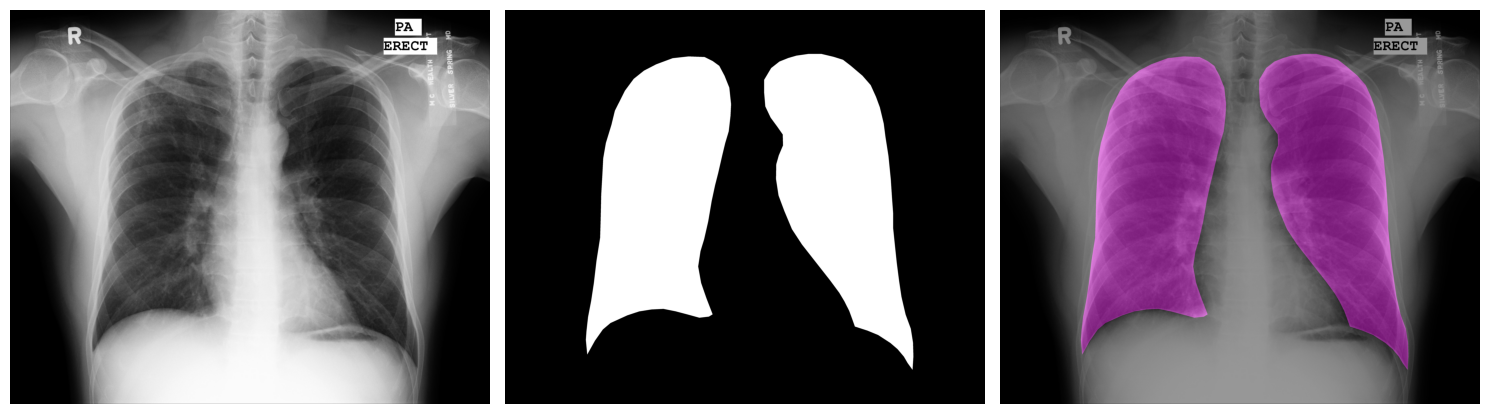

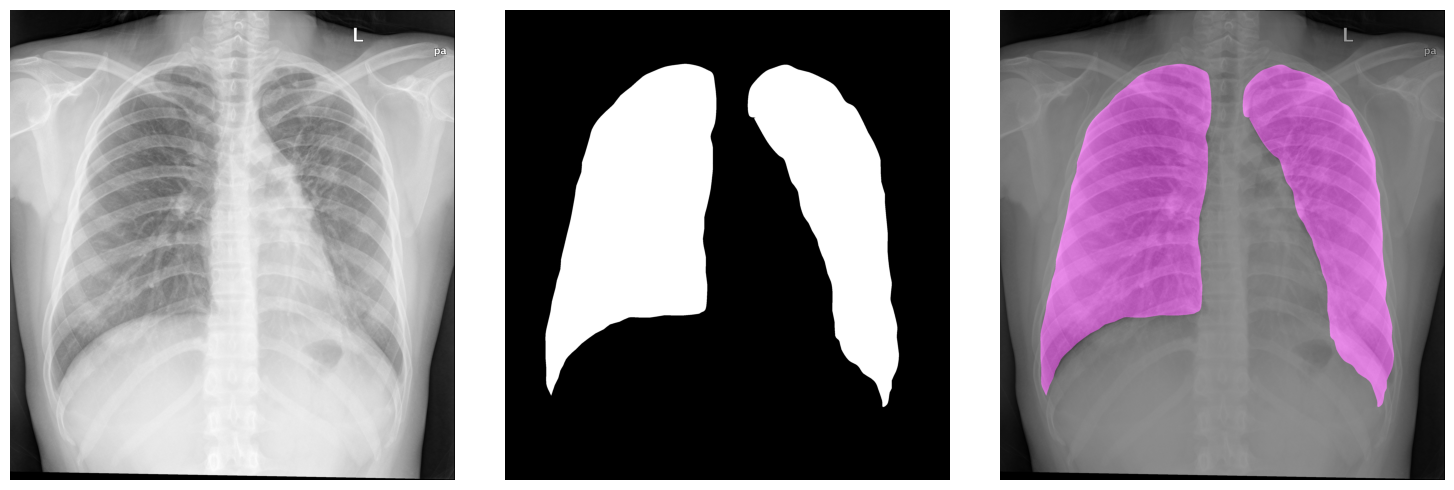

In [8]:
def get_colored_mask(image, mask_image,color = [255,20,255]):
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray)
    mask_coord = np.where(mask!=[0,0,0])
    mask[mask_coord[0],mask_coord[1],:]= color
    ret = cv2.addWeighted(image, 0.6, mask, 0.4, 0)
    return ret
    
filenames = next(os.walk(IMG_PATH))[2][:3]
for file in filenames:
    img = imread(IMG_PATH+file)
    msk = imread(MSK_PATH+file)

    plt.figure(figsize=(15,5))

    plt.subplot(131)
    plt.imshow(img)
    plt.yticks([])
    plt.xticks([])
    plt.box(False)
    
    plt.subplot(132)
    plt.imshow(msk,cmap='binary_r')
    plt.yticks([])
    plt.xticks([])
    plt.box(False)

    plt.subplot(133)
    plt.imshow(get_colored_mask(img,msk))
    plt.yticks([])
    plt.xticks([])
    plt.box(False)

    plt.tight_layout()
    plt.show()

100%|██████████| 704/704 [00:14<00:00, 50.07it/s]


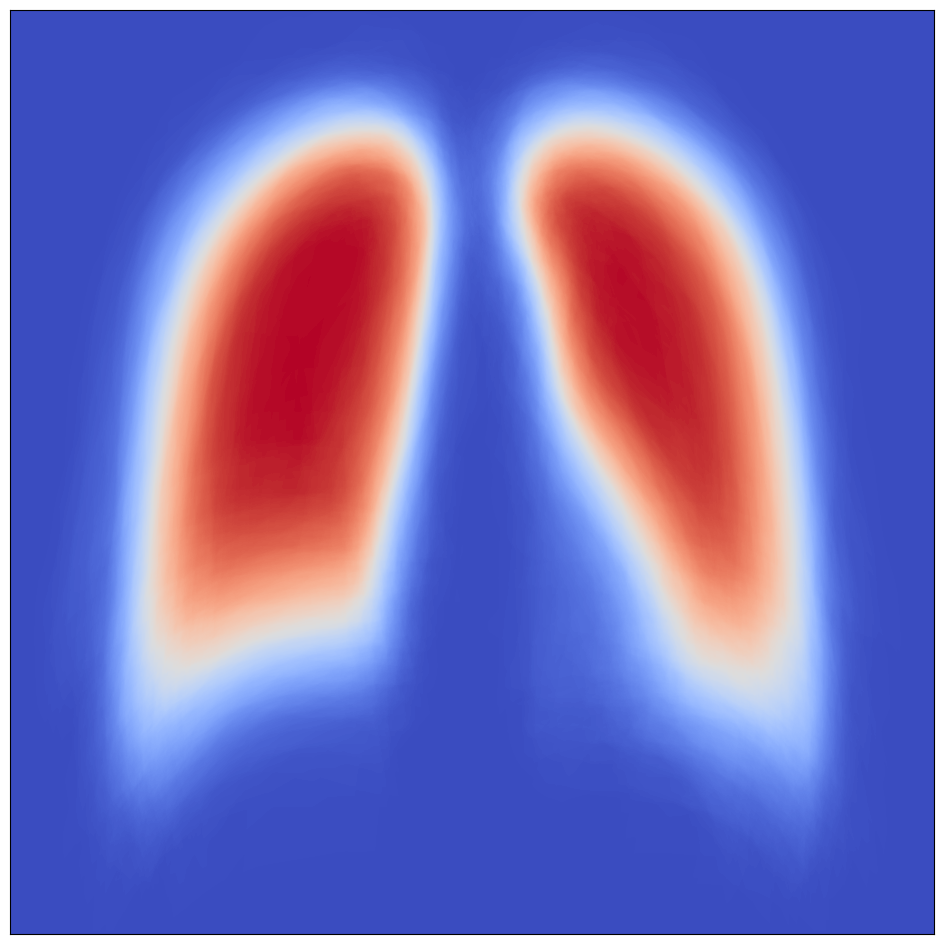

In [9]:
filenames = next(os.walk(IMG_PATH))[2]
heatmap = np.zeros((1024,1024))
for file in tqdm(filenames,total=len(filenames)):
    msk = imread(MSK_PATH+file,0)
    msk = resize(msk,(1024,1024))
    heatmap += msk
heatmap /= len(filenames)
  
plt.figure(figsize=(12,12))

plt.imshow(heatmap,cmap='coolwarm')
plt.yticks([])
plt.xticks([])

plt.show()

In [10]:
from tensorflow.keras.utils import Sequence

from tensorflow.keras.utils import Sequence
import numpy as np
import cv2
import os
from skimage.transform import resize  # still using skimage for resize

class DataGenerator(Sequence):
    def __init__(self, img_files, mask_files, batch_size=32, size=(256, 256), seed=1, shuffle=True):
        self.img_filenames = img_files
        self.mask_filenames = mask_files
        self.batch_size = batch_size
        self.size = size
        self.seed = seed
        self.shuffle = shuffle

        assert len(self.img_filenames) == len(self.mask_filenames), \
            "The number of images and masks must be the same"

        self.indexes = np.arange(len(self.img_filenames))
        if self.shuffle:
            self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.img_filenames) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]

        images = []
        masks = []

        for idx in batch_indices:
            # Load grayscale image using OpenCV
            img_path = os.path.join(IMG_PATH, self.img_filenames[idx])
            mask_path = os.path.join(MSK_PATH, self.mask_filenames[idx])

            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = resize(img, self.size, mode='constant', preserve_range=True)
            img = img / 255.0
            img = np.expand_dims(img, axis=-1)

            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = resize(mask, self.size, mode='constant', preserve_range=True)
            mask = mask / 255.0
            mask[mask > 0.5] = 1
            mask = np.expand_dims(mask, axis=-1)

            images.append(img)
            masks.append(mask)

        return np.array(images), np.array(masks)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)



img_files, msk_files = sorted(os.listdir(IMG_PATH)), sorted(os.listdir(MSK_PATH))

train_img_files, val_img_files, train_msk_files, val_msk_files = train_test_split(img_files,msk_files,test_size=0.3,random_state=1)

train_data = DataGenerator(
    img_files=train_img_files,
    mask_files=train_msk_files,
    batch_size=8,
    size=(256, 256)
)

val_data = DataGenerator(
    img_files=val_img_files,
    mask_files=val_msk_files,
    batch_size=8,
    size=(256, 256)
)


# <p style="font-size: 36px;background-color:#6A0DAD; color:white; padding:10px 20px; width:95%; border-radius:15px; text-align:center;margin: 0 auto;font-weight: bold;">U-Net Acritecture Overview</p>
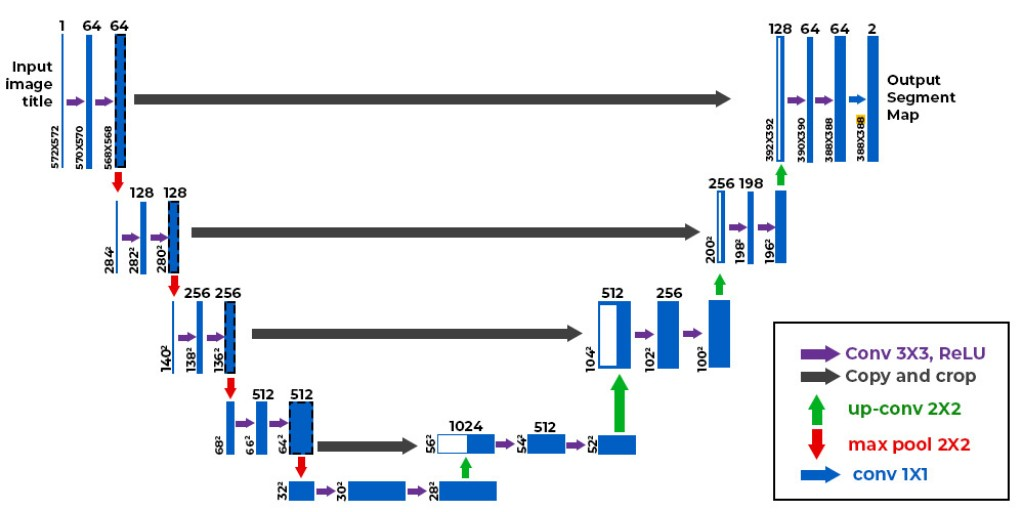

U-Net consists of two main paths: the **Contracting Path** and the **Expansive Path**. It follows an encoder-decoder structure.

## <p style="font-size: 36px;background-color:#6A0DAD; color:white; padding:10px 20px; width:95%; border-radius:15px; text-align:center;margin: 0 auto;font-weight: bold;">Explanation of Key Components</p>
1. **Input Layer**: The model starts with an input layer defined by the shape of the images, which in this case is `(256, 256, 1)` for grayscale images.
2. **Contracting Path (Encoder)**:
   - The encoder consists of three convolutional blocks, each followed by ReLU activations and max pooling for downsampling.
   - Each block captures features at increasing levels of complexity, starting from basic features with 64 filters to more complex features with 256 filters.
3. **Bottleneck**:
   - The bottleneck consists of two convolutional layers with 512 filters, which captures the most complex features of the input image.
4. **Expansive Path (Decoder)**:
   - The decoder also has three blocks that mirror the encoder. Each block consists of upsampling followed by concatenation with the corresponding encoder block to retain spatial information.
   - Each upsampling block reduces the number of filters, starting from 256 down to 64.
5. **Output Layer**:
   - The final layer outputs the segmentation map with the same width and height as the input image, using a 1x1 convolution and a sigmoid activation function for binary segmentation.
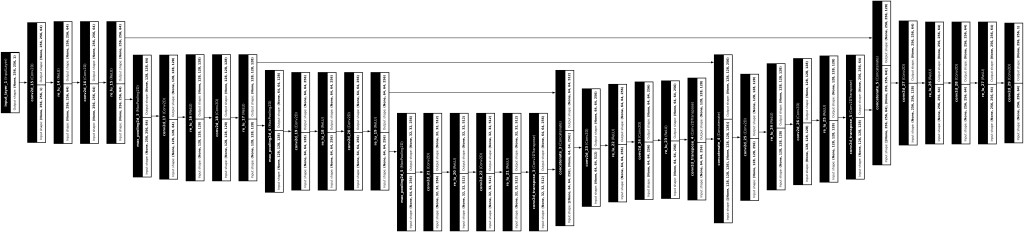

In [11]:
def unet(input_shape, num_classes):
    # Input layer for the model
    inputs = layers.Input(shape=input_shape)
    
    # Contracting Path (Encoder)
    # First block with 64 filters
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.BatchNormalization()(conv1)  # Add Batch Normalization
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = layers.BatchNormalization()(conv1)  # Add Batch Normalization
    pool1 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(conv1)  # Downsample

    # Second block with 128 filters
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.BatchNormalization()(conv2)  # Add Batch Normalization
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = layers.BatchNormalization()(conv2)  # Add Batch Normalization
    pool2 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(conv2)  # Downsample

    # Third block with 256 filters
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.BatchNormalization()(conv3)  # Add Batch Normalization
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = layers.BatchNormalization()(conv3)  # Add Batch Normalization
    pool3 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(conv3)  # Downsample

    # Bottleneck layer with 512 filters
    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = layers.BatchNormalization()(conv4)  # Add Batch Normalization
    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = layers.BatchNormalization()(conv4)  # Add Batch Normalization

    # Expansive Path (Decoder)
    # First upsampling block
    up6 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv4)  # Upsample
    merge6 = layers.concatenate([up6, conv3])  # Concatenate with the corresponding encoder block
    conv6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(merge6)
    conv6 = layers.BatchNormalization()(conv6)  # Add Batch Normalization
    conv6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = layers.BatchNormalization()(conv6)  # Add Batch Normalization

    # Second upsampling block
    up7 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6)  # Upsample
    merge7 = layers.concatenate([up7, conv2])  # Concatenate with the corresponding encoder block
    conv7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(merge7)
    conv7 = layers.BatchNormalization()(conv7)  # Add Batch Normalization
    conv7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = layers.BatchNormalization()(conv7)  # Add Batch Normalization

    # Third upsampling block
    up8 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7)  # Upsample
    merge8 = layers.concatenate([up8, conv1])  # Concatenate with the corresponding encoder block
    conv8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(merge8)
    conv8 = layers.BatchNormalization()(conv8)  # Add Batch Normalization
    conv8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = layers.BatchNormalization()(conv8)  # Add Batch Normalization

    # Output layer for segmentation
    outputs = layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(conv8)

    # Create the model
    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model  # Return the model

# Instantiate the model
input_shape = (256, 256, 1)  # Define the input shape for grayscale images
model = unet(input_shape, 1)  # Create U-Net model for binary segmentation

# Print the model summary
model.summary()  # Display model architecture


2025-07-09 18:13:22.605236: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-09 18:13:22.605435: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-09 18:13:22.605513: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         640       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['batch_normalization[0][0

In [12]:
# Jaccard Index Metric
def jaccard_index(y_true, y_pred, smooth=100):
    """Calculates the Jaccard index (IoU), useful for evaluating the model's performance."""
    y_true_f = tf.reshape(tf.cast(y_true, tf.float32), [-1])  # Flatten and cast ground truth
    y_pred_f = tf.reshape(tf.cast(y_pred, tf.float32), [-1])  # Flatten and cast predictions
    intersection = tf.reduce_sum(y_true_f * y_pred_f)  # Compute intersection
    total = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection  # Total pixels
    return (intersection + smooth) / (total + smooth)


def dice_coefficient(y_true, y_pred, smooth=1):
    # Flatten and cast true and predicted masks to float32
    y_true_f = tf.reshape(tf.cast(y_true, tf.float32), [-1])  # Flatten and cast y_true to float32
    y_pred_f = tf.reshape(tf.cast(y_pred, tf.float32), [-1])  # Flatten and cast y_pred to float32
    
    # Calculate the intersection between the true and predicted masks
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    
    # Calculate the Dice coefficient using the formula
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


# Using the metrics in model compilation
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy',dice_coefficient,jaccard_index])

# <p style="font-size: 36px;background-color:#6A0DAD; color:white; padding:10px 20px; width:95%; border-radius:15px; text-align:center;margin: 0 auto;font-weight: bold;">Train The Model</p>

In [ ]:
# ## ModelCheckpoint: Save the model with the best validation loss during training
# checkpoint = ModelCheckpoint(
#     'best_model.keras',            # Path to save the model
#     monitor='val_dice_coefficient',         # Metric to monitor 
#     verbose=1,                  # Print messages when saving the model
#     save_best_only=True,        # Save only the best model (with highest metric)
#     mode='max',                 # 'max' means the model with the highest metric score will be saved
#     save_weights_only=False,     # Save the entire model (not just weights)
# )

# # Fit the model with multi-processing enabled
# history = model.fit(
#     train_data,
#     validation_data=val_data,
#     epochs=50,
#     workers=4,
#     use_multiprocessing=True,
#     callbacks=[...]
# )

from tensorflow.keras.callbacks import ModelCheckpoint

# Callback to save the best model based on dice coefficient
checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_dice_coefficient',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=False,
)

# Train the model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=100,
    workers=4,
    use_multiprocessing=True,
    callbacks=[checkpoint]
)


Epoch 1/100


2025-07-09 18:13:37.965272: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2025-07-09 18:13:45.367020: I external/local_xla/xla/service/service.cc:168] XLA service 0x707167808680 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-07-09 18:13:45.367066: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-07-09 18:13:45.377438: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1752065025.467532   27866 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-07-09 18:13:57.410209: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.16GiB with freed_by_count=0. The caller

61/61 [==============================] - ETA: 0s - loss: 0.2151 - accuracy: 0.9046 - dice_coefficient: 0.7835 - jaccard_index: 0.6530
Epoch 1: val_dice_coefficient improved from -inf to 0.40119, saving model to best_model.keras
61/61 [==============================] - 183s 3s/step - loss: 0.2151 - accuracy: 0.9046 - dice_coefficient: 0.7835 - jaccard_index: 0.6530 - val_loss: 50.3158 - val_accuracy: 0.2497 - val_dice_coefficient: 0.4012 - val_jaccard_index: 0.2515
Epoch 2/100
61/61 [==============================] - ETA: 0s - loss: 0.0973 - accuracy: 0.9469 - dice_coefficient: 0.8932 - jaccard_index: 0.8075
Epoch 2: val_dice_coefficient did not improve from 0.40119
61/61 [==============================] - 168s 3s/step - loss: 0.0973 - accuracy: 0.9469 - dice_coefficient: 0.8932 - jaccard_index: 0.8075 - val_loss: 1.0698 - val_accuracy: 0.7238 - val_dice_coefficient: 0.0277 - val_jaccard_index: 0.0148
Epoch 3/100
61/61 [==============================] - ETA: 0s - loss: 0.0760 - accuracy

Process Keras_worker_ForkPoolWorker-1330:
Traceback (most recent call last):
  File "/home/ccc/anaconda3/envs/tf/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/ccc/anaconda3/envs/tf/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ccc/anaconda3/envs/tf/lib/python3.10/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/home/ccc/anaconda3/envs/tf/lib/python3.10/site-packages/keras/src/utils/data_utils.py", line 648, in get_index
    return _SHARED_SEQUENCES[uid][i]
  File "/tmp/ipykernel_27756/1018412009.py", line 40, in __getitem__
    img = resize(img, self.size, mode='constant', preserve_range=True)
  File "/home/ccc/anaconda3/envs/tf/lib/python3.10/site-packages/skimage/transform/_warps.py", line 207, in resize
    _clip_warp_output(image, out, mode, cval, clip)
  File "/home/ccc/anaconda3/envs/tf/lib/python3.10/site-pac

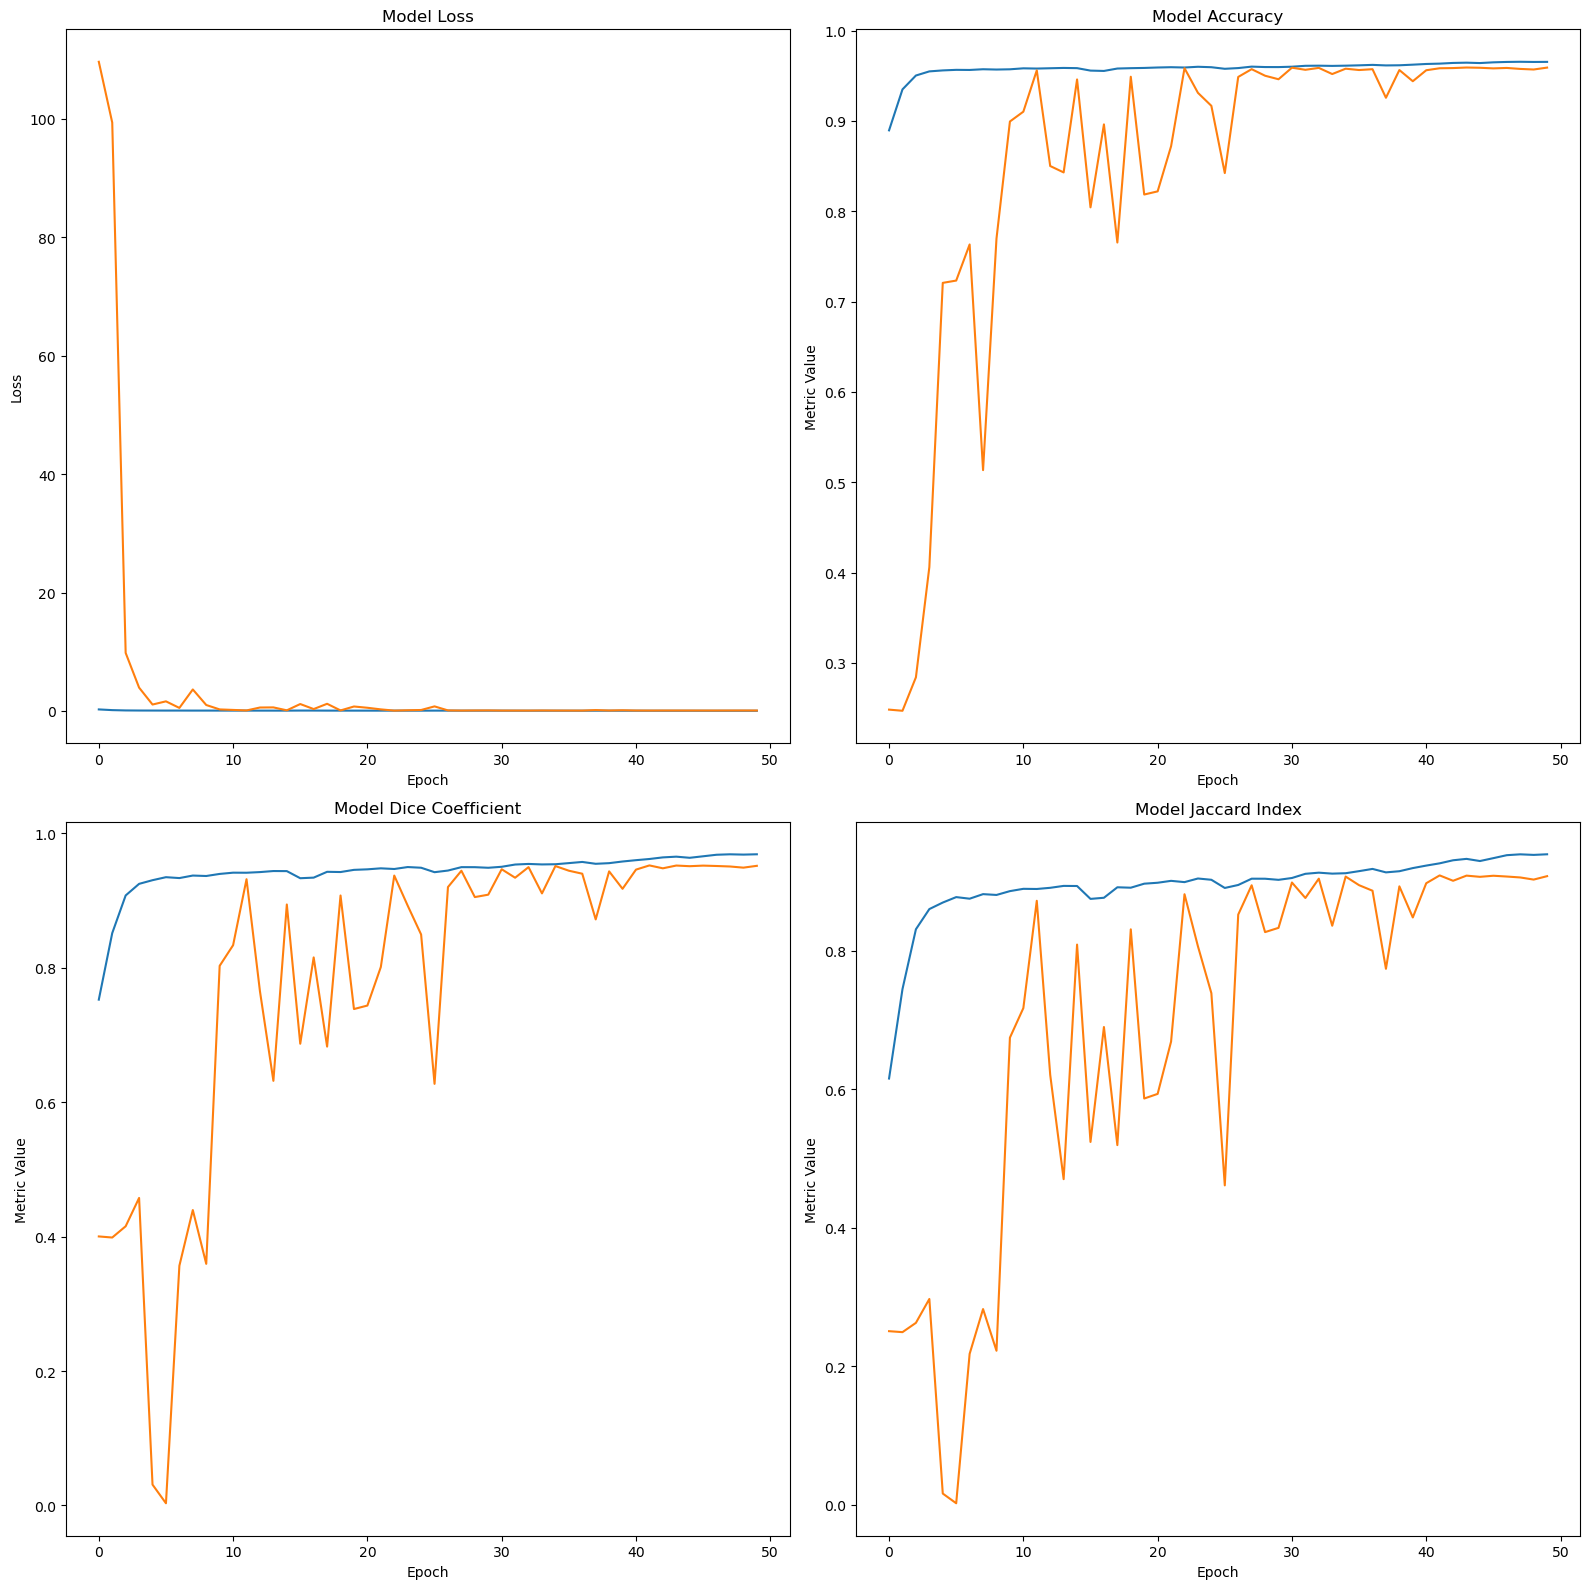

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(16,16))
plt.subplot(221)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.subplot(222)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Metric Value')
plt.xlabel('Epoch')

plt.subplot(223)
plt.plot(history.history['dice_coefficient'], label='Train Dice Coefficient')
plt.plot(history.history['val_dice_coefficient'], label='Validation Dice Coefficient')
plt.title('Model Dice Coefficient')
plt.ylabel('Metric Value')
plt.xlabel('Epoch')

plt.subplot(224)
plt.plot(history.history['jaccard_index'], label='Train Jaccard Index')
plt.plot(history.history['val_jaccard_index'], label='Validation Jaccard Index')
plt.title('Model Jaccard Index')
plt.ylabel('Metric Value')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()

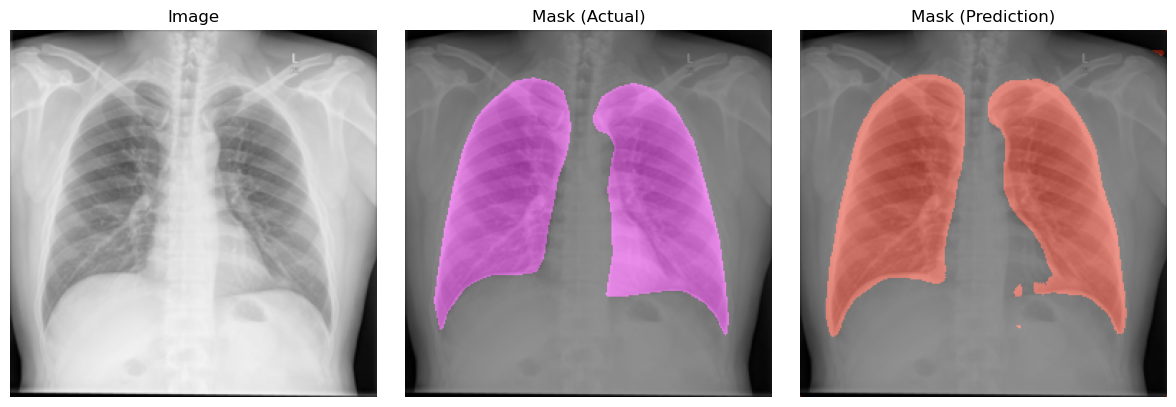

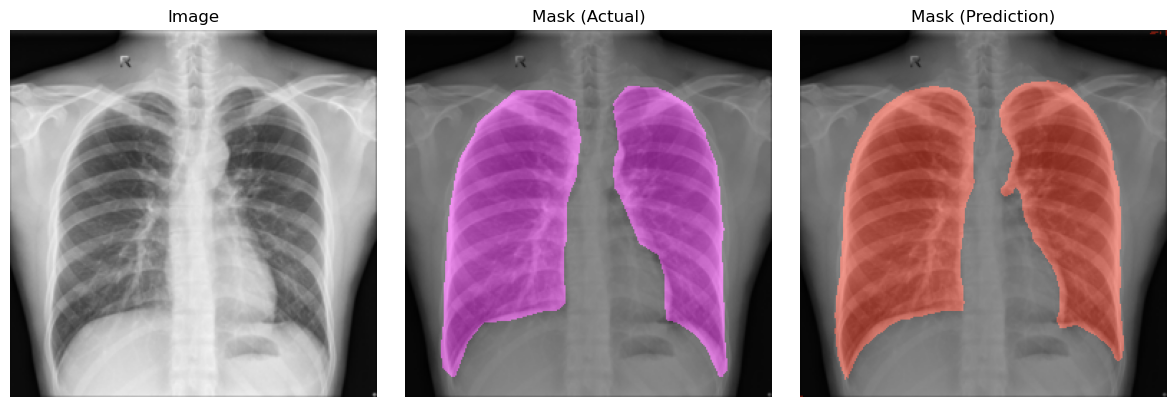

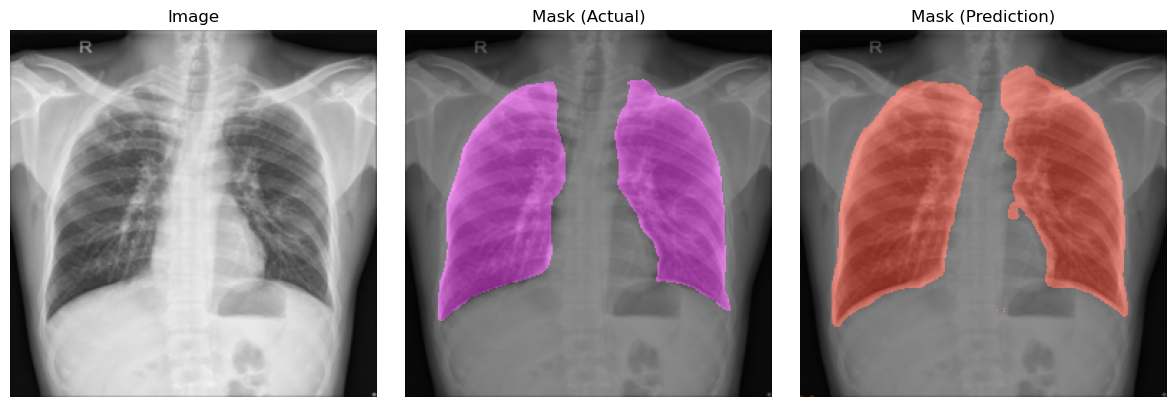

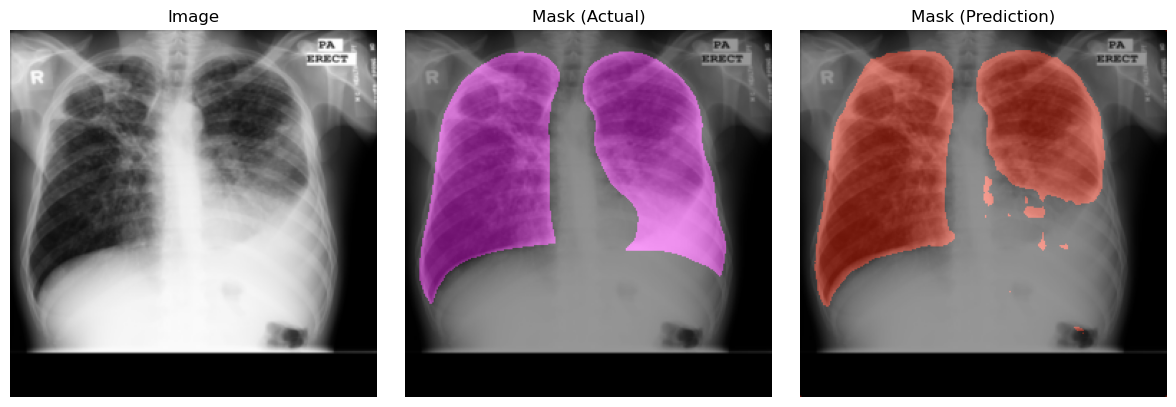

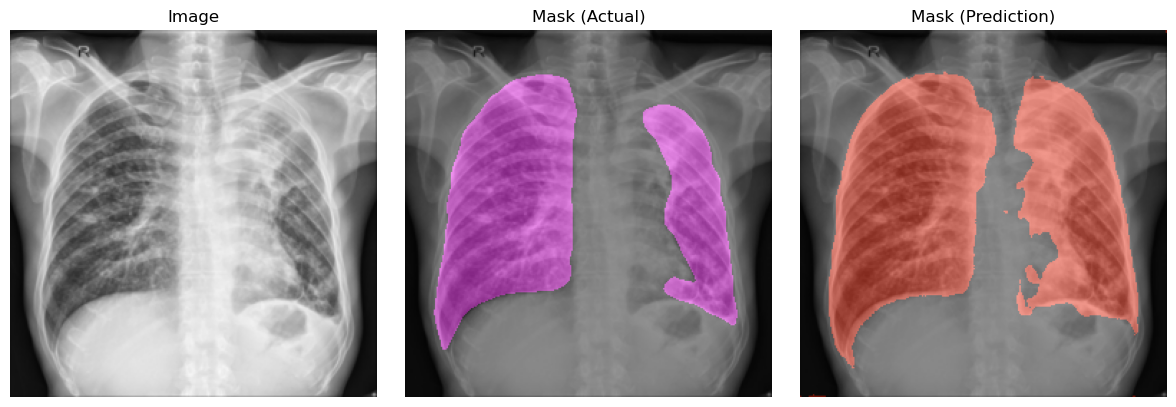

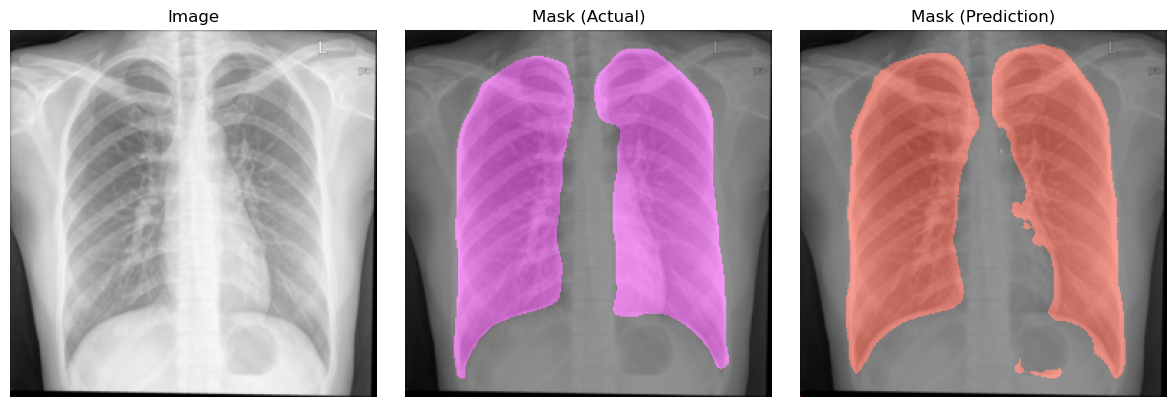

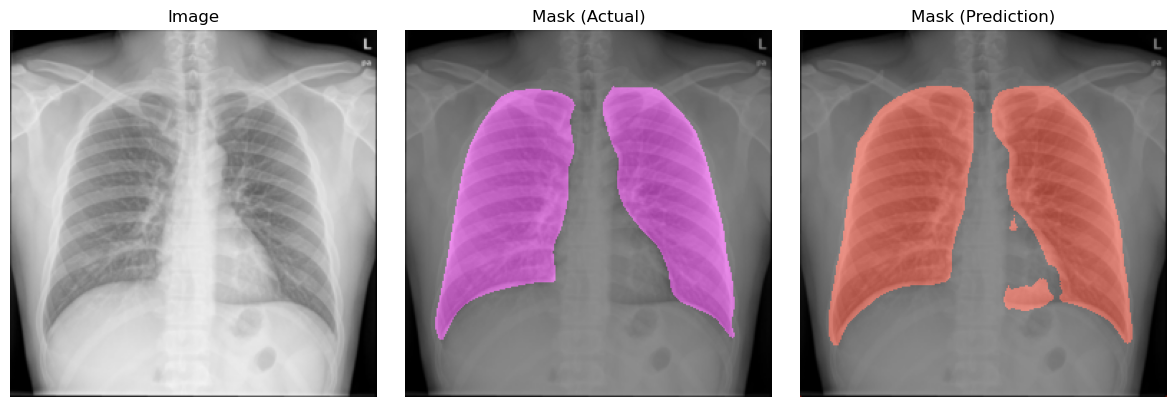

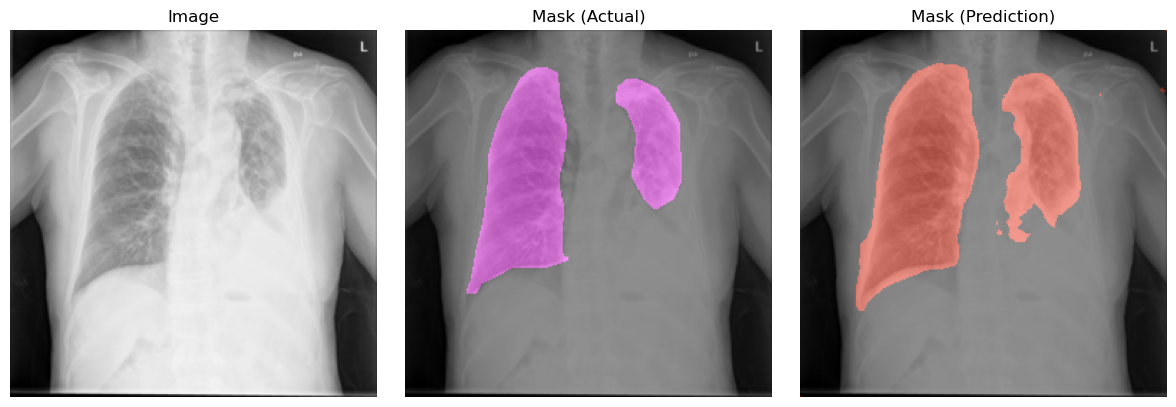

In [ ]:
imgs, msks  = val_data.__getitem__(1)

for img,msk in zip(imgs,msks):
    img = np.expand_dims(img, axis=0)
    pred = (np.squeeze(model.predict(img,verbose=0))*255).astype(np.uint8)
    img = (np.squeeze(img) * 255).astype(np.uint8)
    msk = (msk*255).astype(np.uint8)

    # Convert grayscale image to RGB
    img= cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    msk = cv2.cvtColor(msk, cv2.COLOR_GRAY2RGB)
    pred = cv2.cvtColor(pred, cv2.COLOR_GRAY2RGB)
    
    plt.figure(figsize=(12,4))

    plt.subplot(131)
    plt.imshow(img)
    plt.title('Image')
    plt.yticks([])
    plt.xticks([])
    plt.box(False)
    
    plt.subplot(132)
    plt.imshow(get_colored_mask(img,msk))
    plt.title('Mask (Actual)')
    plt.yticks([])
    plt.xticks([])
    plt.box(False)

    plt.subplot(133)
    plt.imshow(get_colored_mask(img,pred,color = [255,30,0]))
    plt.title('Mask (Prediction)')
    plt.yticks([])
    plt.xticks([])
    plt.box(False)

    plt.tight_layout()
    plt.show()